- I created a new conda environment to install keras
- Then I created a second keras environment to install Keras 2.3.1 due to bugs.

In [37]:
import numpy as np

npzfile = np.load('/home/dyllanjr/Solar_Irradiance_Prediction/data/processed/Arkansas_look_back_48.npz')

In [38]:
Xs = npzfile['x']
y = npzfile['y']

#Have to drop the last element of y
y = y[:-1]

In [126]:
Xs.shape

(7299, 48, 8)

In [39]:
import keras
import numpy as np

In [40]:
### I need to split my Xs into categorical and numericals
#I'm going to just use the numerical columns first.
cat_data = Xs[:,:,[0,2]]
num_data = Xs[:,:,[1,3,4,5,6,7]]

['Cloud Type',
 'Dew Point',
 'Fill Flag',
 'Wind Speed',
 'Surface Albedo',
 'Temperature',
 'Solar Zenith Angle',
 'Wind Direction']

In [63]:
from keras.layers import Embedding, Reshape, Dense, Concatenate, Lambda, BatchNormalization,TimeDistributed
from keras.layers.recurrent import GRU, RNN
from keras.models import Sequential, Input
from keras import backend
import pandas as pd

In [118]:
# One embedding for each categorical feature (cloud type and fill flag)

#cloud type c1, fill_flag c2
c1 = cat_data[:, :, 0]
c2 = cat_data[:, :, 1]

#Embedding for cloud type
num_unique1 = pd.DataFrame(c1).nunique().max()
embedding_size1 = min(np.ceil((num_unique1)/2), 50)
embedding_size1 = int(embedding_size1)
vocab1 = num_unique1+1
embed1_in = Input(shape=(48,), name='cloud_type')
embedding1 = Embedding(vocab1, embedding_size1, input_length = 48)
x1 = embedding1(embed1_in)

#Embedding for fill flag
num_unique2 = pd.DataFrame(c2).nunique().max()
embedding_size2 = min(np.ceil((num_unique2)/2), 50)
embedding_size2 = int(embedding_size2)
vocab2 = num_unique2+1
embed2_in = Input(shape=(48,), name='fill_flag')
embedding2 = Embedding(vocab2, embedding_size2, input_length = 48)
x2 = embedding2(embed2_in)

#Input for numerical data
numerical_in = Input(shape=(48, 6), name='numerical')

#concat inputs of embedding layerse and numerical data
cat_nums = Concatenate(axis=2)([x1, x2, numerical_in])

batch_norm = BatchNormalization()(cat_nums)

#GRU is more computationally efficient
l1 = GRU(250, return_sequences=False)(batch_norm)

#final output layer
d1 = Dense(1, activation='sigmoid')(l1)

## sum half-hourly GHI predictions for daily total GHI prediction
# def summer(x):
#     return backend.sum(x, axis=1)

# summed_output = Lambda(summer)(output)
#Instantiate model
model = keras.Model(
    inputs=[embed1_in, embed2_in, numerical_in],
    outputs=[d1])

/home/dyllanjr/Solar_Irradiance_Prediction/reports/figures


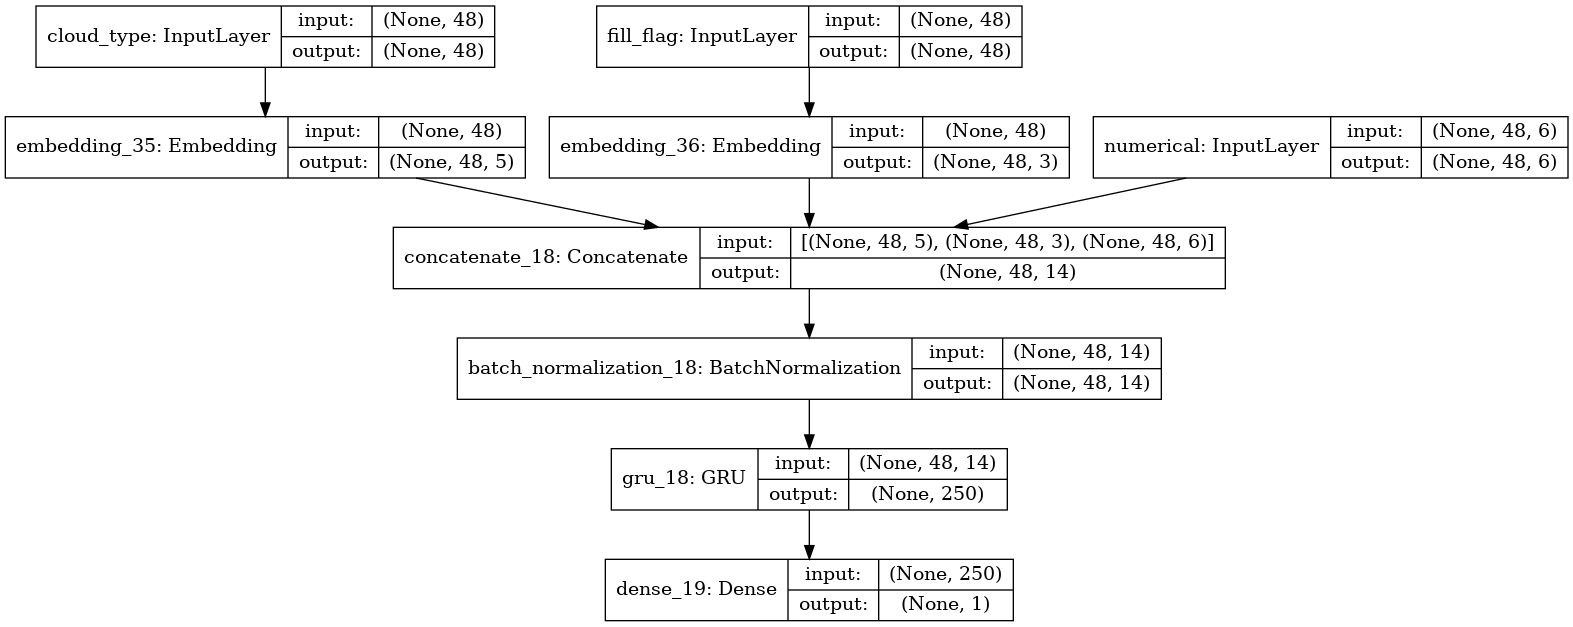

In [119]:
%cd /home/dyllanjr/Solar_Irradiance_Prediction/reports/figures
from keras.utils import plot_model

plot_model(model, 'GRU_with_embedding.png', show_shapes = True)

In [120]:
import tensorflow as tf

In [121]:
#Set optimizer and loss function
model.compile(
    loss='mse',
    optimizer=tf.optimizers.Adam()
)

In [122]:
#Train-test splitting numerical and categorical data features

cat_train, cat_test= np.split(cat_data, [int(.850 *len(cat_data))])
cloud_train, cloud_test = cat_train[:, :, 0], cat_test[:, :, 0]
fill_flag_train, fill_flag_test = cat_train[:, :, 1], cat_test[:, :, 1]
num_train, num_test = np.split(num_data, [int(.850 *len(num_data))])

#Train-test splitting target 
#sum each batch (one day of values, 48 half hours)
y_sum = np.sum(y, axis=1)
y_train, y_test = np.split(y_sum, [int(.850 *len(y_sum))])

In [91]:
y_train[0].shape

(48, 1)

In [92]:
int(.850 *len(cat_data))

6204

In [93]:
int(.850 *len(y_sum))

6204

In [94]:
y[0]

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [ 26],
       [103],
       [190],
       [276],
       [355],
       [424],
       [481],
       [523],
       [551],
       [563],
       [559],
       [540],
       [504],
       [455],
       [392],
       [143],
       [116],
       [147],
       [ 63],
       [  0],
       [  0]], dtype=int32)

In [95]:
Xs.shape

(7299, 48, 8)

In [96]:
num_train.shape

(6204, 48, 6)

In [123]:
model.fit(
    x={'cloud_type': cloud_train, 'fill_flag': fill_flag_train, 'numerical': num_train},
    y=y_train,
    epochs=200,
    batch_size=32,
    use_multiprocessing=True)

Epoch 1/200
6204/6204 [==============================] - 126s 20ms/step - loss: 107384845.6015
Epoch 2/200
6204/6204 [==============================] - 119s 19ms/step - loss: 107384551.6132
Epoch 3/200
6204/6204 [==============================] - 119s 19ms/step - loss: 107384552.0825
Epoch 4/200
6204/6204 [==============================] - 118s 19ms/step - loss: 107384551.2469
Epoch 5/200
6204/6204 [==============================] - 119s 19ms/step - loss: 107384551.6028
Epoch 6/200
6204/6204 [==============================] - 123s 20ms/step - loss: 107384551.8298
Epoch 7/200
6204/6204 [==============================] - 121s 19ms/step - loss: 107384551.5770
Epoch 8/200
6204/6204 [==============================] - 129s 21ms/step - loss: 107384551.5770
Epoch 9/200
6204/6204 [==============================] - 128s 21ms/step - loss: 107384551.8917
Epoch 10/200
6204/6204 [==============================] - 125s 20ms/step - loss: 107384551.3346
Epoch 11/200
6204/6204 [=========================

6204/6204 [==============================] - 121s 19ms/step - loss: 107384551.8143
Epoch 87/200
6204/6204 [==============================] - 121s 20ms/step - loss: 107384551.2418
Epoch 88/200
6204/6204 [==============================] - 123s 20ms/step - loss: 107384551.6596
Epoch 89/200
6204/6204 [==============================] - 121s 19ms/step - loss: 107384551.1850
Epoch 90/200
6204/6204 [==============================] - 120s 19ms/step - loss: 107384551.1077
Epoch 91/200
6204/6204 [==============================] - 122s 20ms/step - loss: 107384550.8137
Epoch 92/200
6204/6204 [==============================] - 122s 20ms/step - loss: 107384551.7008
Epoch 93/200
6204/6204 [==============================] - 124s 20ms/step - loss: 107384551.0767
Epoch 94/200
6204/6204 [==============================] - 123s 20ms/step - loss: 107384551.4687
Epoch 95/200
6204/6204 [==============================] - 124s 20ms/step - loss: 107384551.8917
Epoch 96/200
6204/6204 [=============================

6204/6204 [==============================] - 117s 19ms/step - loss: 107384551.5152
Epoch 171/200
6204/6204 [==============================] - 115s 19ms/step - loss: 107384551.8298
Epoch 172/200
6204/6204 [==============================] - 116s 19ms/step - loss: 107384551.6493
Epoch 173/200
6204/6204 [==============================] - 118s 19ms/step - loss: 107384550.5042
Epoch 174/200
6204/6204 [==============================] - 117s 19ms/step - loss: 107384551.2676
Epoch 175/200
6204/6204 [==============================] - 116s 19ms/step - loss: 107384551.7782
Epoch 176/200
6204/6204 [==============================] - 116s 19ms/step - loss: 107384551.8504
Epoch 177/200
6204/6204 [==============================] - 117s 19ms/step - loss: 107384552.0516
Epoch 178/200
6204/6204 [==============================] - 116s 19ms/step - loss: 107384551.6132
Epoch 179/200
6204/6204 [==============================] - 120s 19ms/step - loss: 107384551.6183
Epoch 180/200
6204/6204 [===================

In [18]:
test_score = model.evaluate(
    {'cloud_type': cloud_test, 'fill_flag': fill_flag_test, 'numerical': num_test},
    y_test, verbose=2)
print("Test loss:", np.sqrt(test_score))


Test loss: 10229.513771614611


In [19]:
model.save('/home/dyllanjr/Solar_Irradiance_Prediction/models/EmbeddedLSTM.h5')

/home/dyllanjr/anaconda3/envs/kerasenv2/lib/python3.8/site-packages/keras/engine/saving.py:164: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  warnings.warn(


In [21]:
from keras.models import load_model

In [ ]:
test_model = load_model('/home/dyllanjr/Solar_Irradiance_Prediction/models/test.h5')

In [ ]:
test_model.compile(
    loss='mse',
    optimizer=tf.optimizers.Adam()
)

In [ ]:
test_score = test_model.evaluate(
    {'cloud_type': cloud_test, 'fill_flag': fill_flag_test, 'numerical': num_test},
    y_test, verbose=2)
print("Test loss:", np.sqrt(test_score))

In [ ]:
#Try this later
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

 def build_model():
    model = Sequential()

    # Filters = utils in Dense Total number of Features 
    # Padding : 'same' : Zero Padding - Add a zero pixels around the entire image
    # Conv1D - filters + kernel + padding + relu
    model.add(Conv1D( filters = 64, kernel_size = 6, activation = 'relu', padding = 'same', input_shape = (187, 1)))
    # Signal Normalization to avoid overfitting
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPooling1D(pool_size=(3), strides = (2), padding='same'))

    model.add(Conv1D( filters = 64, kernel_size = 6, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides = (2), padding='same'))

    model.add(Conv1D( filters = 64, kernel_size = 6, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides = (2), padding='same'))

    # Flatten 
    model.add(Flatten())

    # Dense - Fully Connected Layer 
    # Input Layer 
    model.add(Dense( units = 64, activation = 'relu'))

    # Hidden Layer 
    model.add(Dense( units = 64, activation = 'relu'))

    # Output -
    model.add(Dense( units = 5, activation = 'softmax'))

    # categorical_crossentropy - Multiclass Classification 
    model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model